<a href="https://colab.research.google.com/github/GIHng/Stock_Prediction_RNN/blob/main/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

sam = pd.read_csv("/content/sample_data/samsung-2.csv") #작업 경로에 csv파일을 지정해줘야 함. yahoo financial에서 5개년치 삼성전자 주식.
sam = sam.sort_index(ascending=False)
sam=sam.reset_index() #columns 순서 맞추기 위함.
sam=sam.drop(["index"], axis=1)

In [114]:
def calMACD(df, short=12, long=26, signal = 9):
  df['MACD'] = df['Close'].ewm(span = short, min_periods = short-1, adjust = False).mean() - df['Close'].ewm(span = long, min_periods = long-1, adjust=False).mean()
  df['MACD_Signal'] = df['MACD'].ewm(span = signal, min_periods = signal-1, adjust=False).mean()
  df['MACD_OSC'] = df['MACD'] - df['MACD_Signal']
  return df

print(calMACD(sam))

           Date   Open   High    Low  Close    Adj Close    Volume  \
0     2023.6.30  72500  72700  71700  72300  72300.00000   3891411   
1     2023.6.28  72600  72700  72000  72700  72700.00000   8783093   
2     2023.6.27  72500  72600  72000  72600  72600.00000   9442997   
3     2023.6.26  71700  72500  71500  72400  72400.00000  10541901   
4     2023.6.23  72000  72200  71600  71600  71600.00000  12329484   
...         ...    ...    ...    ...    ...          ...       ...   
1226   2018.7.6  45500  45850  44650  44900  39064.31250  17843706   
1227   2018.7.5  46100  46550  45600  45950  39977.84375   7039773   
1228   2018.7.4  46700  47050  46050  46250  40238.84766   8776763   
1229   2018.7.3  45750  46450  45750  46150  40151.85547  10959655   
1230   2018.7.2  46500  47150  45500  45550  39629.82813  13112253   

            MACD  MACD_Signal    MACD_OSC  
0            NaN          NaN         NaN  
1            NaN          NaN         NaN  
2            NaN          N

# 새 섹션

In [115]:
scaler = MinMaxScaler()
sam["Close"]=scaler.fit_transform(sam["Close"].values.reshape(-1,1)) #데이터가 scaling을 위함. 0~1까지의 값을 가질 수 있도록.
data=sam["Close"]
print(data)

0       0.650794
1       0.658263
2       0.656396
3       0.652661
4       0.637722
          ...   
1226    0.139122
1227    0.158730
1228    0.164332
1229    0.162465
1230    0.151261
Name: Close, Length: 1231, dtype: float64


In [116]:
def make_dataset(data, window_size = 10): #sequence는 10으로, input size는 1로 설정함.
    feature_list =[]
    label_list =[]
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(data.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)


data_X, data_Y = make_dataset(data)

train_data, train_label = data_X[:-100], data_Y[:-100]
test_data, test_label = data_X[-100:], data_Y[-100:]


In [117]:
train_data = torch.FloatTensor(train_data) #학습할 수 있는 형태로 변환
train_label = torch.FloatTensor(train_label) #학습할 수 있는 형태로 변환
train_data=train_data.view(train_data.shape[0],10,-1)
train_label=train_label.view(train_data.shape[0],1)

train_rnn = torch.utils.data.TensorDataset(train_data, train_label)
train_loader =torch.utils.data.DataLoader(dataset = train_rnn, batch_size =train_data.shape[0], shuffle = False)

## Test
test_data = torch.FloatTensor(test_data)
test_label = torch.FloatTensor(test_label)
test_data=test_data.view(test_data.shape[0],10,-1)


test_rnn = torch.utils.data.TensorDataset(test_data, test_label)
test_loader =torch.utils.data.DataLoader(dataset = test_rnn, batch_size =train_data.shape[0], shuffle = False)

In [118]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    def forward(self,x):
        x, _status = self.rnn(x)
        x = self.fc(x[:,-1])
        return x

model = RNN(input_dim=1,hidden_dim=30,output_dim=1,layers=2)
loss_fn = nn.MSELoss(reduction ="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Optimizer로 Adam을 사용함

for epoch in range(500): #epoch의 수
    for i,(train_, label_) in enumerate(train_loader):
    #     print(train_)
    #     print(label_)
        optimizer.zero_grad()
        y_pred = model(train_)
        loss = loss_fn(label_, y_pred) #loss_fn : 손실(loss)을 갖는 텐서를 반환하는 손실 함수
        loss.backward()
        optimizer.step()
    if epoch % 50 ==0:
        print(epoch ,loss.item())

0 0.45639902353286743
50 0.00080772495130077
100 0.0004665383603423834
150 0.00042654480785131454
200 0.000403407437261194
250 0.0003866186016239226
300 0.0003733878256753087
350 0.0003625300305429846
400 0.00035349675454199314
450 0.00034594981116242707


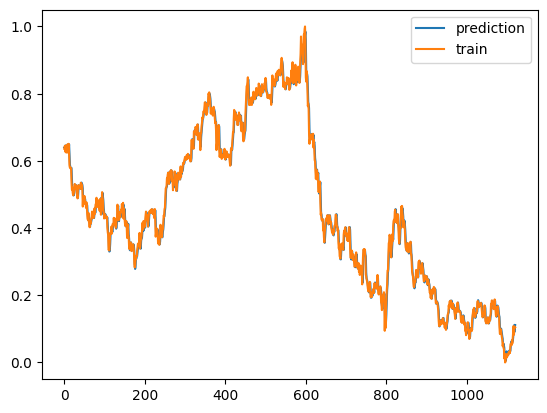

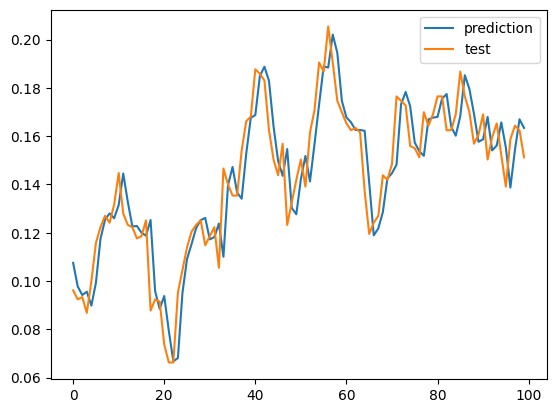

In [119]:
# scaled된 데이터로 학습 및 예측

#학습
plt.plot(y_pred.detach().numpy(), label ="prediction")
plt.plot(train_label, label="train")
plt.legend()
plt.show()

#테스트
y_test_pred = model(test_data)
plt.plot(y_test_pred.detach().numpy(), label ="prediction")
plt.plot(test_label, label="test")
plt.legend()
plt.show()



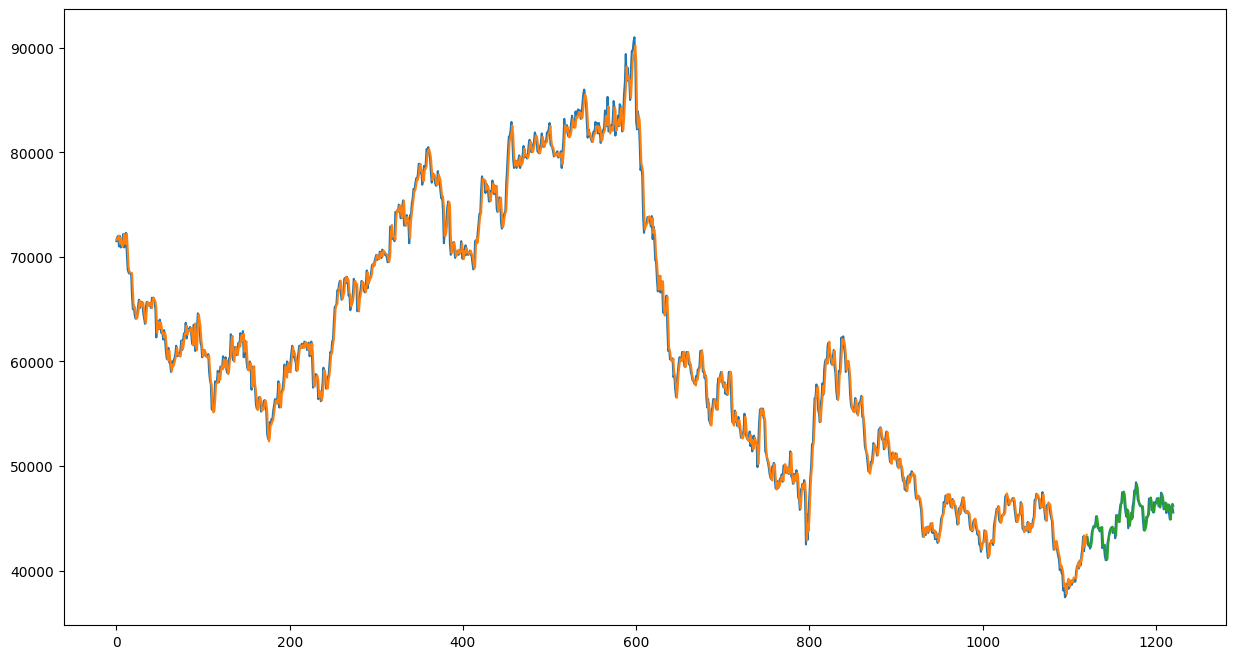

In [120]:
y_train_pred = model(train_data)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()) # 실제 훈련 데이터의 형태로 변형하기 위해 이미 스케일된 값을 자연수 형태로 변경

y_test_pred = model(test_data)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()) # 실제 훈련 데이터의 형태로 변형하기 위해 이미 스케일된 값을 자연수 형태로 변경

trainPredictPlot = np.empty_like(sam.iloc[10:]["Close"])
trainPredictPlot[:]=np.nan
trainPredictPlot[0:len(y_train_pred)] = y_train_pred[:,0] #학습 값

testPredictPlot = np.empty_like(sam.iloc[10:]["Close"])
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_pred):len(sam.iloc[10:]["Close"])+1] = y_test_pred[:,0] # train된 데이터를 기반으로 다음 예측 값을 넣음


plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(sam.iloc[10:]["Close"].values.reshape(-1,1)), label='shape') #실제 데이터
plt.plot(trainPredictPlot, label='train') # 학습 부분
plt.plot(testPredictPlot, label='test') # 예측 부분
plt.show()



In [121]:

# def calMACD(df, short=12, long=26, signal = 9):
#   df['MACD'] = df['Close'].ewm(span = long, min_periods = long-1, adjust = False).mean() - df['Close'].ewm(span = long, min_periods = long-1, adjust=False).mean()
#   df['MACD_Signal'] = df['MACD'].ewm(span = signal, min_periods = signal-1, adjust=False).mean()
#   df['MACD_OSC'] = df['MACD'] - df['MACD_Signal']
#   return df

# print(calMACD(data))